# EDA
KSSL & LUCAS VNIR Exploratory Data Analysis (EDA)

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import r2_score
import umap

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, 
                                    AnalytesTfm, SNVTfm, AvgTfm, GADFTfm, 
                                    ResizeTfm, LogTfm, asTabular)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

analyte_name = 725

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [3]:
root_dir = Path('../../_data/') if device != 'cuda' else Path('.')

## Utilities

In [4]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=IndexSplitter([]),
                       item_tfms=[AvgTfm],
                       batch_tfms=[SNVTfm,
                                   LogTfm])

    return dblock.dataloaders(paths, bs=bs, num_workers=6)

## Data loading

In [5]:
analytes = ['725'] # Kex

paths_kssl = get_paths(root_dir/'kssl-vnir', analytes=analytes)
paths_lucas = get_paths(root_dir/'lucas-vnir', analytes=analytes)
paths_all = paths_kssl + paths_lucas; paths_all

100%|██████████| 21782/21782 [00:17<00:00, 1260.70it/s]


(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [11]:
# Collate all KSSL & LUCAS data
(X_kssl, y_kssl), (X_lucas, y_lucas) = (asTabular(get_dls(p, bs=32).train) 
                                        for p in [paths_kssl, paths_lucas])

100%|██████████| 680/680 [01:04<00:00, 10.62it/s]


In [ ]:
fname_dump = Path('../files/dump') / 'vnir-all-tab.pkl'
save_pickle(fname_dump,
            ((X_kssl, y_kssl), (X_lucas, y_lucas)))

## Data visualization

In [2]:
fname_dump = Path('../files/dump') / 'vnir-all-tab.pkl'
(X_kssl, y_kssl), (X_lucas, y_lucas) = load_pickle(fname_dump)

### Target (Kex) histograms

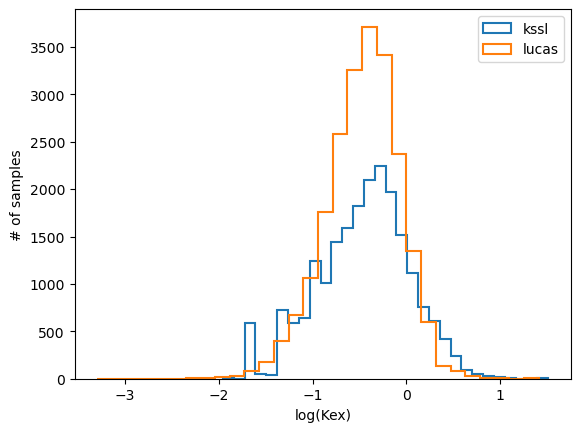

In [4]:
fig, ax = plt.subplots()

kwargs_hist = {
    'alpha': 1,
    'lw': 1.5,
    'density': False,
    'histtype': 'step',
    'bins': 30}

ax.hist(y_kssl, **kwargs_hist, label='kssl')
ax.hist(y_lucas, **kwargs_hist, label='lucas')

ax.set_xlabel('log(Kex)')
ax.set_ylabel('# of samples')

ax.legend()

### UMap

#### All wavelength

In [18]:
len(X_kssl)

20928

In [23]:
labels = np.r_[np.ones(len(X_kssl)) ,
               np.zeros(len(X_lucas))]

In [40]:
X_all = np.r_[X_kssl, X_lucas]

mapper = umap.UMAP(n_neighbors=5,
                   metric='cosine').fit(X_all)
X_all_umap = mapper.fit_transform(X_all)

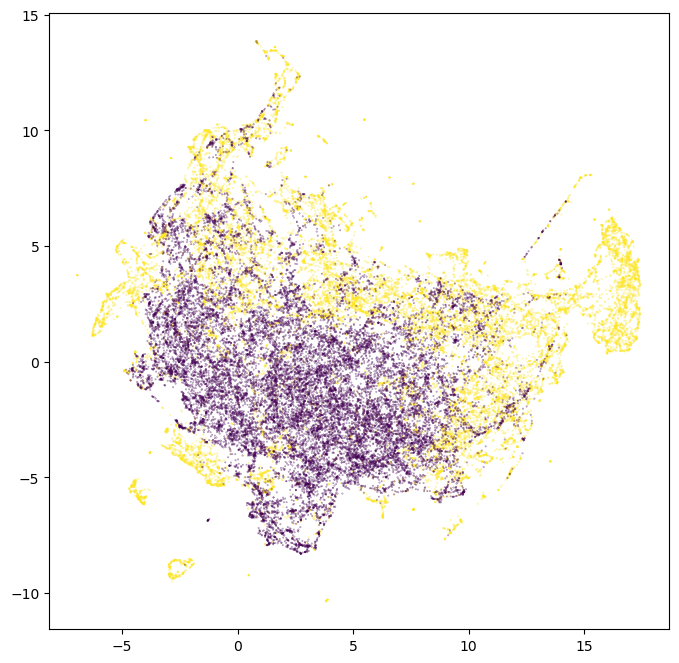

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

kwargs_hist = {
    'alpha': 0.6,
    's': 0.1}

ax.scatter(X_all_umap[:, 0], X_all_umap[:, 1], c=labels, **kwargs_hist)

#### Mineralogical regions only

Based on: 
- Viscarra Rossel, R.A., 2011. Fine-resolution multiscale mapping of clay minerals in Australian soils measured with near infrared spectra. Journal of Geophysical Research: Earth Surface 116.


In [30]:
wl= np.arange(500, 2451)
kaolinite = 2165
illite = 2345
smectite = 1912

In [31]:
def get_indices(center_wl, bandwidth=25):
    idx_start = np.where(wl == (center_wl - bandwidth))
    idx_end = np.where(wl == (center_wl + bandwidth))
    return [idx[0].item() for idx in [idx_start, idx_end]]

idx_start, idx_end = get_indices(kaolinite)

In [38]:
mapper = umap.UMAP(n_neighbors=5,
                   metric='cosine').fit(X_all[:, idx_start:idx_end])

X_all_umap = mapper.fit_transform(X_all[:, idx_start:idx_end])

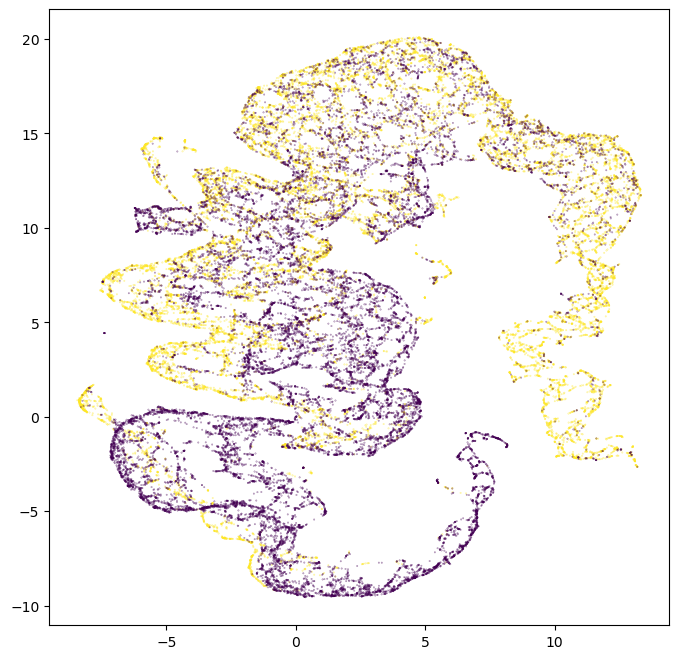

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

kwargs_hist = {
    'alpha': 0.6,
    's': 0.1}

ax.scatter(X_all_umap[:, 0], X_all_umap[:, 1], 
           c=labels, **kwargs_hist)

#ax.legend();